------------------------------------------------
Simple Multimodal Vector Implementation
=========================================

In this notebook we demonstrate a simple pipeline to combine text and image data into a unified vector representation. For the text we create a simple (deterministic) “random” vector based on the text content, and for the image we convert it to grayscale, resize it, and flatten it into a vector. Finally, we concatenate the two vectors.
------------------------------------------------

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import hashlib

------------------------------------------------
Helper Functions for Text and Image Vectorization
=========================================

In this cell, we define two helper functions that are essential for converting text and image data into numerical vectors, which we can later combine to form a multimodal representation.
These helper functions are the foundation for building our multimodal vector representation by individually processing textual and visual data i.e image.
------------------------------------------------

In [2]:
def text_to_vector(text, dim=10):
    """
    Converts text into a fixed-dimensional vector.
    Here we use a simple method based on hashing so that the same text
    always produces the same vector.
    """
    # Create a hash of the text to use as a seed for generating a random vector
    text_hash = int(hashlib.md5(text.encode('utf-8')).hexdigest(), 16)
    rng = np.random.RandomState(text_hash % (2**32))
    return rng.rand(dim)

def image_to_vector(image, target_size=(32, 32)):
    """
    Converts an image into a vector.
    The image is converted to grayscale, resized to target_size, normalized,
    and flattened.
    """
    # Convert image to grayscale
    image = image.convert('L')
    # Resize image
    image = image.resize(target_size)
    # Convert to NumPy array and normalize pixel values to [0,1]
    arr = np.array(image) / 255.0
    # Flatten the 2D image into a 1D vector
    return arr.flatten()

------------------------------------------------
MultiModalVector Class
=========================================
This cell defines the *MultiModalVector* class. The purpose of this class is to combine both text and image data into a single, unified vector representation.
This class serves as the core module for fusing multimodal inputs and can later be used for tasks such as retrieval, recommendation, or further processing in your pipeline.
------------------------------------------------

In [3]:
class MultiModalVector:
    """
    A simple class that fuses text and image data into one vector.
    """
    def __init__(self, text_dim=10):
        self.text_dim = text_dim
        
    def combine(self, text, image):
        """
        Converts text and image into vectors and concatenates them.
        """
        txt_vec = text_to_vector(text, self.text_dim)
        img_vec = image_to_vector(image)
        # Concatenate text and image vectors along the feature axis
        multimodal_vec = np.concatenate([txt_vec, img_vec])
        return multimodal_vec

------------------------------------------------
Load Local Image & Generate Multimodal Vector
=========================================
In this cell, we demonstrate how to load a local image and create a multimodal vector by combining the image with an associated text description. 
------------------------------------------------

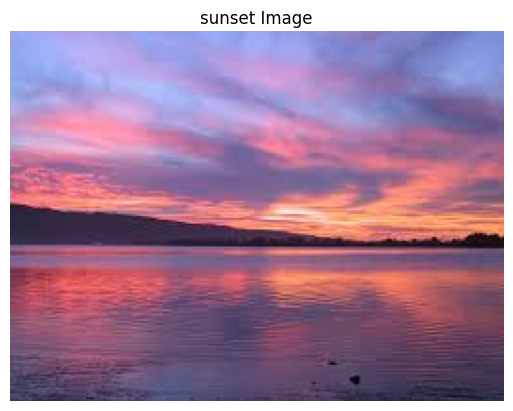

Multimodal vector shape: (1034,)
First 10 elements of the multimodal vector: [0.20598916 0.28500099 0.70212631 ... 0.16862745 0.18431373 0.2       ]
1034


In [4]:
import os

local_image_path = 'sunset.jfif' 

if os.path.exists(local_image_path):
    sample_image = Image.open(local_image_path)
    
    # show the loaded image
    plt.imshow(sample_image)
    plt.title("sunset Image")
    plt.axis('off')
    plt.show()
    
    # text input
    sample_text = "Dusky sky meets ocean"
    
    # Instantiate multimodal vector handler
    muv = MultiModalVector(text_dim=10)
    
    # Combine the inputs into a single multimodal vector
    multi_vector = muv.combine(sample_text, sample_image)
    
    print("Multimodal vector shape:", multi_vector.shape)
    print("First 10 elements of the multimodal vector:", multi_vector)
    print(len(multi_vector))
else:
    print("The specified image file does not exist. Please check the file path.")

------------------------------------------------
# Multimodal Product Retrieval with Static Query

This cell demonstrates a complete use case where we build a small product dataset and perform content‐based retrieval using multimodal embeddings. The key steps are as follows:

1. **Dataset Creation:**
   - **Image Paths & Product Descriptions:**  
     - We define a dictionary `image_paths` that maps product labels (e.g., "red_dress", "green_jacket", "blue_shirt") to the corresponding local image file paths.
     - A corresponding `sample_texts` dictionary provides descriptive text for each product.
   - **Vector Database Construction:**  
     - For each product, the code checks if the specified image file exists. If it does, the image is loaded and paired with its text description.
     - Using the `MultiModalVector` instance (with a text dimension of 10), each product’s image and text are converted into numerical vectors via the `combine()` method.
     - These multimodal vectors are stored in a list called `dataset_vectors` while product metadata (text, image, file path) is saved in `dataset_items`.
   - **Dataset Preparation:**  
     - The list of vectors is converted into a NumPy array to facilitate efficient similarity computations.

2. **Query Definition:**
   - **Static Query Text & Image:**  
     - A query text is defined (e.g., "I'm looking for a stylish outfit with bold colors.").
     - A query image is loaded from a local file path (`query_image_path`). (Note: The provided query image here is different from those used to build the dataset.)
   - **Query Vectorization:**  
     - The query text and image are processed to form a multimodal query vector using the same `MultiModalVector` instance.

3. **Similarity Computation & Retrieval:**
   - **Cosine Similarity Calculation:**  
     - Cosine similarity is computed between the query vector and each product vector in the dataset using scikit-learn’s `cosine_similarity`.
   - **Best Match Selection:**  
     - The product with the highest similarity score is identified as the best match. Details such as the product's text description, image file path, and the similarity score are printed.
   - **Visualization:**  
     - Finally, the query image and the best matching product image are displayed side-by-side for visual comparison.

This cell provides a practical demonstration of how multimodal vector representations can be used for product retrieval and recommendation based on combined text and image features.
------------------------------------------------

Cosine similarities with each dataset item: [0.97032364 0.91948389 0.95557108]

Best match found:
Text Description: A trendy red dress perfect for summer evenings.
Image Path: red_dress.jfif
Similarity Score: 0.9703


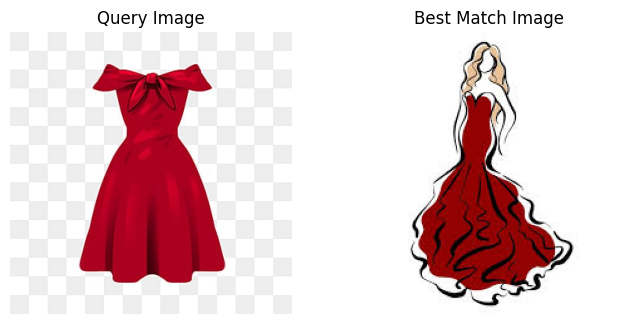

In [5]:
import os
from PIL import Image

image_paths = {
    "red_dress": "red_dress.jfif",
    "green_jacket": "green_jacket.jfif",
    "blue_shirt": "blue_shirt.jfif"
}
query_image_path = "red_dress.jpg"

# Corresponding text descriptions for each product
sample_texts = {
    "red_dress": "A trendy red dress perfect for summer evenings.",
    "green_jacket": "A refreshing green jacket ideal for casual outings.",
    "blue_shirt": "A bold blue shirt suitable for formal events."
}

# Instantiate the multimodal vector handler
muv = MultiModalVector(text_dim=10)

dataset_vectors = []
dataset_items = []

for key in image_paths:
    path = image_paths[key]
    if os.path.exists(path):
        # Load the image from the local path
        item_image = Image.open(path)
        text = sample_texts[key]
        vector = muv.combine(text, item_image)
        dataset_vectors.append(vector)
        dataset_items.append({"text": text, "image": item_image, "path": path})
    else:
        print("Image not found at path:", path)

# Convert dataset vectors to a NumPy array for similarity comparisons
dataset_vectors = np.array(dataset_vectors)

# ---------------------------
# Now, define a query
query_text = "I'm looking for a stylish outfit with bold colors."
# For the query image, 
# query_image_path = image_paths["blue_shirt"]

if os.path.exists(query_image_path):
    query_image = Image.open(query_image_path)
else:
    print("Query image not found at:", query_image_path)
    query_image = None

if query_image:
    # Compute the query's multimodal embedding.
    query_vector = muv.combine(query_text, query_image)

    # Compute cosine similarities between the query vector and each dataset vector
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity([query_vector], dataset_vectors)[0]

    print("Cosine similarities with each dataset item:", similarities)

    # Retrieve the best matching item
    best_match_index = np.argmax(similarities)
    best_match = dataset_items[best_match_index]

    print("\nBest match found:")
    print("Text Description:", best_match["text"])
    print("Image Path:", best_match["path"])
    print("Similarity Score: {:.4f}".format(similarities[best_match_index]))

    # Optionally, display the query and best match images side-by-side.
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(best_match["image"])
    plt.title("Best Match Image")
    plt.axis("off")
    plt.show()

------------------------------------------------
# Vector Database Overview

In this cell, we provide an overview of our vector database (the collection of multimodal embeddings for our dataset). Specifically, we:

- Print the total number of items stored in the vector database.
- Iterate over each vector and display:
  - The shape of the vector, showing the dimensions of the multimodal representation.
  - The first 5 elements of the vector, which gives a quick look at the numerical values.
------------------------------------------------

In [6]:
print("Vector Database Overview:")
print("Total number of items in the DB:", len(dataset_vectors))
for i, vec in enumerate(dataset_vectors):
    print(f"Item {i}:")
    print("  Vector shape:", vec.shape)
    print("  First 5 elements:", vec[:5])
print("\n---------------------------------------\n")

Vector Database Overview:
Total number of items in the DB: 3
Item 0:
  Vector shape: (1034,)
  First 5 elements: [0.398859   0.12921907 0.52657589 0.83685429 0.70056311]
Item 1:
  Vector shape: (1034,)
  First 5 elements: [0.12919753 0.00878298 0.71766325 0.76099692 0.51396603]
Item 2:
  Vector shape: (1034,)
  First 5 elements: [0.45883934 0.59814704 0.45150022 0.0214465  0.07560197]

---------------------------------------



In [7]:
query_text = "I am looking for a stylish blue outfit."  # Your query text
query_image_path = "green_shirt.jfif"  # Path to your local query image; update if needed

if os.path.exists(query_image_path):
    query_image = Image.open(query_image_path)
else:
    raise FileNotFoundError("Query image not found at: " + query_image_path)

# Compute the query multimodal vector
query_vector = muv.combine(query_text, query_image)
print("Query vector shape:", query_vector.shape)

Query vector shape: (1034,)


------------------------------------------------
# Cosine Similarity Calculation & Best Match Retrieval

In this cell, we perform the following:

1. **Cosine Similarity Calculation:**
   - We use scikit-learn’s `cosine_similarity` function to compute the similarity between the multimodal query vector and each vector in our dataset.
   - The result is an array of similarity scores (one for each dataset item), where higher values indicate greater similarity.

2. **Displaying Similarities:**
   - The code prints the similarity score for each dataset item, formatted to 4 decimal places.
   - This helps us inspect how well the query matches each item in our vector database.

3. **Best Match Retrieval:**
   - The dataset item with the highest cosine similarity (i.e., the best match) is identified using `similarities.argmax()`.
   - Details of this best match—its text description, associated image path, and the similarity score—are printed to the console.

This cell allows us to determine which product from our dataset best matches the query based on the combined text and image features.
------------------------------------------------

In [8]:
similarities = cosine_similarity([query_vector], dataset_vectors)[0]
print("\nCosine similarities between the query and each dataset item:")
for idx, sim in enumerate(similarities):
    print(f"Item {idx}: Similarity = {sim:.4f}")

# Find the best matching item
best_match_index = similarities.argmax()
best_match = dataset_items[best_match_index]

print("\nBest match found:")
print("Text Description:", best_match["text"])
print("Image Path:", best_match.get("path", "N/A"))
print("Similarity Score: {:.4f}".format(similarities[best_match_index]))


Cosine similarities between the query and each dataset item:
Item 0: Similarity = 0.9482
Item 1: Similarity = 0.9410
Item 2: Similarity = 0.9592

Best match found:
Text Description: A bold blue shirt suitable for formal events.
Image Path: blue_shirt.jfif
Similarity Score: 0.9592


------------------------------------------------
Visualize Query and Best Match Images
=========================================
This visualization provides a quick, intuitive way to verify that the retrieval system is matching the query image with the most similar item.
------------------------------------------------

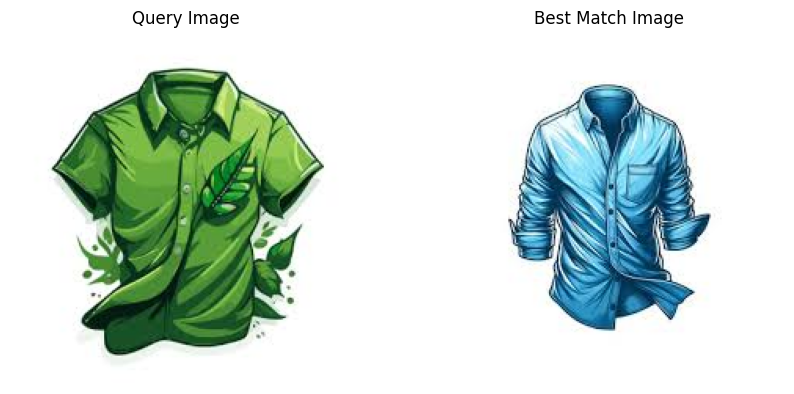

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(query_image)
plt.title("Query Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_match["image"])
plt.title("Best Match Image")
plt.axis("off")

plt.show()